# Devoir 3 - IFT6512

(Julia language) In this notebook, we will implement the *retrospective approximation* variant of sample-average approximation for Monte Carlo stochastic optimization, to model the response variable of a bank marketing campaign. The full data is available [here](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#).

In [1]:
using JuMP
using LinearAlgebra
using Distributions
using CSV
using DataFrames
using Plots
using LaTeXStrings

DATA_SOURCE = "data/bank-full.csv"

# Optimization hyperparameters
α = 0.1                   # Learning rate
MAX_ITER = 2000           # To avoid optimizations going on for ever
MAX_ROUNDS_STOPPING = 5   # To avoid optimizations stopping too quickly


(process:8184): GLib-GIO-WARNING **: 14:20:57.222: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_15.8.7.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


5

## Data Loading and Problem Statement

We have 16 independent variables to predict a binary dependent variable, indicating whether the call was a success or not.

In [2]:
data = CSV.read(DATA_SOURCE, DataFrame, delim=";")
println(size(data))
data[1:5, :]

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact
,Int64,String15,String15,String15,String3,Int64,String3,String3,String15
1,58,management,married,tertiary,no,2143,yes,no,unknown
2,44,technician,single,secondary,no,29,yes,no,unknown
3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown
4,47,blue-collar,married,unknown,no,1506,yes,no,unknown
5,33,unknown,single,unknown,no,1,no,no,unknown


## Data preprocessing

We start by one-hot encoding categorical variables, i.e. by replacing each categorical column by a matrix of binary variables indicating the belongingness of each observation to each possible value of that variable.  

NB: the way we do this bakes in a redundant column for each variable. If we have $k$ mutually exclusive categories, we could encode all the available information using $k-1$ columns, each one representing a given category $j\in\{1,...,k-1\}$, with the $k^{th}$ category indicated by the negation of all other categories, i.e. a row of zeros. This simplification, however, is slightly more complicated to code, so we will not bother with it here.

In [3]:
function OHencode(df, uniques_dict)
    
    for k in keys(uniques_dict)
        u = uniques_dict[k]
        new_cols = transpose(u .== permutedims(df[:, k]))
        new_cols = DataFrame(Dict(string(String(k), "_", u[i]) => new_cols[:, i] for i in 1:length(u)))
        df = hcat(
            select(df, Not(k)),
            new_cols)
    end
    
    return df
end

# Isolate the categorical independent variables
desc = describe(data)
categorical = desc[[supertype(t) == InlineString for t in desc.eltype], :variable]
categorical = categorical[[t != :y for t in categorical]]

# Encode the categorical columns using binary "one-hot" variables
uniques = Dict(col => unique(data[:, col]) for col in categorical)
encoded_data = OHencode(data, uniques)

# Separate independent and response variables
full_X = select(encoded_data, Not(:y))
full_y = [r == "yes" for r in encoded_data.y]

println("Categorical variables: ", categorical)

Categorical variables: [:job, :marital, :education, :default, :housing, :loan, :contact, :month, :poutcome]


We will also center and scale the numerical variables, to avoid scaling problems during the optimization:  
$$\tilde x_j \leftarrow \frac{x_j - \mu_j}{\sigma_j}$$
with $\mu_j$ and $\sigma_j$ the sample mean and standard deviation, respectively, of variable $j$. To avoid leakage, for now we merely code the function to perform this, which we will call at each step of the optimization algorithm as sample subsets change.

In [4]:
function get_numerical_cols(df)
    desc = describe(df)
    valid = [!(supertype(t) in [InlineString, Integer]) for t in desc.eltype]
    return desc[valid, :variable]
end

numerical = get_numerical_cols(encoded_data)
println("Numerical variables: ", numerical)

function center_scale(df, targets, μ=missing, σ=missing)
    
    for i in 1:length(targets)
        col = targets[i]
        x = float.(df[:, col])
        μ_ = ismissing(μ) ? mean(x) : μ[i]
        σ_ = ismissing(σ) ? std(x) : σ[i]
        
        df = hcat(
            df[:, Not(col)],
            DataFrame(Dict(String(col) => (x .- μ_) ./ σ_))
        )
    end
    return df
end

test_encoding = center_scale(data, numerical)
test_encoding[1:5, numerical]

Numerical variables: [:age, :balance, :day, :duration, :campaign, :pdays, :previous]


,age,balance,day,duration,campaign,pdays,previous
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.60695,0.256416,-1.29846,0.011016,-0.569344,-0.411449,-0.251938
2,0.288526,-0.43789,-1.29846,-0.416122,-0.569344,-0.411449,-0.251938
3,-0.747376,-0.446758,-1.29846,-0.707353,-0.569344,-0.411449,-0.251938
4,0.571045,0.0472049,-1.29846,-0.645224,-0.569344,-0.411449,-0.251938
5,-0.747376,-0.447086,-1.29846,-0.233618,-0.569344,-0.411449,-0.251938


## Algorithm

Since we have a binary classification problem, we will implement a logistic regression algorithm. Unlike most problems previously considered in this course, our goal is not really to produce a first-stage decision vector, but rather to find a set of parameters that produce good probability estimates. The problem is the following:  
$$\underset{\beta}{\min} \mathbb{E}_\xi\big[L(\beta, \xi)\big]$$  
Notation:  
- $\beta$ is the parameter vector
- $\xi_i\in\Xi$ is the binary variable we wish to predict, with $\xi_i\in\{0,1\}, \ \forall i\in\{1,...,N_k\}$
- $N_k$ is the sample size at iteration $k$
- $L(\beta, \xi_i)$ is the binary cross-entropy *loss* function, defined as:
    - $L(\hat p_i, \xi_i) \equiv \xi_i\ln(\hat p_i) + (1-\xi_i)\ln(1-\hat p_i)$ with
    - $\hat p_i = \frac{1}{1+\exp(\beta^\top\tilde X_i)} \ \in(0,1)$, where $\tilde X_i$ is the $i^{th}$ observation of the data matrix prepended by a $1$ (for the bias term)
    
### Gradient Descent

Since...  
- the GLPK solver does not accept nonlinear problems,
- it was not possible to install Gurobi or CPLEX on my machine,
- the NLsolve package does not seem to work on problems without roots,
- the Ipopt package, which ostensibly should be able to solve this sort of problem, seems to take extremely long to work (or more likely, I just haven't figured out how to use it properly)

...I decided that it would be easier to just code my own solver rather than spend still more time searching for an off-the-shelf solution. This task is made easier by the convenient fact that the function we wish to optimize is rather easy to differentiate. Using previously-specified notation, and taking:  
- $X$ as the $N_k\times d$ matrix of independent variables
- $\eta \equiv X\beta$
- $\mathbb{I}(\cdot)$ the indicator function with a value of 1 if the expression in parentheses is true, and a value of 0 otherwise  
- $J$ as the jacobian vector
- $\alpha > 0$ as the learning rate (scalar)

We have:
$$\frac{\partial L(\beta, \xi_i)}{\partial \beta_j} = 
\mathbb{I}(\eta_i=0) \frac{X_{ij}}{1+e^\eta} - 
\mathbb{I}(\eta_i=1) \frac{e^\eta X_{ij}}{1+e^\eta}
\Longrightarrow J_j = \sum_{i=1}^{N_k}\frac{\partial L(\beta, \xi_i)}{\partial \beta_j}, \ j={1,...,d}
$$  

Therefore, with a given sample and reasonable starting value for $\beta$, we can easily compute the jacobian vector, which we then use to adjust the coefficients vector. At step $k$:  
$$\beta^k = \beta^{k-1} - \alpha J$$

After each adjustment, we compute the new objective value, and start again until the algorithm converges. We consider ourselves to each an acceptable level of convergeance when **both** of the following conditions have been met for at least 5 consecutive minor iterations, with regards to an externally-supplied $\epsilon>0$ parameter:  
1. the mean objective function has improved by less than $\epsilon$
2. $||J|| < \epsilon$

In [5]:
function objective(β, X, y)
    η = X * β
    p = 1 ./ (1 .+ exp.(η))
    loss = y .* log.(p) + (1 .- y) .* log.(1 .- p)
    return -sum(loss) / size(X)[1]
end

function jacobian(β, X, y)    
    n, d = size(X)
    grad_vec = zeros(d)
    η = X * β
    eη = exp.(η)
    for j = 1:d
        grad = zeros(n)
        for i = 1:n
            grad[i] = y[i] == 1 ? -eη[i] * X[i,j] : X[i,j]
        end
        grad = grad ./ (1 .+ eη)
        grad_vec[j] = -mean(grad)
    end
    return grad_vec
end

function optimize(β, X, y, ϵ)
    
    n, d = size(X)
    X = [ones(n) Matrix(X)]
    progress = []
    
    # Stopping counter
    optimum = Inf
    stopping_counter = 0
    
    # Gradient descent
    for i = 1:MAX_ITER
        
        jac = jacobian(β, X, y)
        β = β .- α .* jac            # Update coefficients
        obj = objective(β, X, y)
        push!(progress, obj)
        
        # Time to stop?
        if max(norm(jac), abs(optimum - obj)) < ϵ
            if stopping_counter >= MAX_ROUNDS_STOPPING
                return β, obj, i, jac, progress
            else
                stopping_counter += 1
            end
        else
            stopping_counter = 0
        end
        
        optimum = min(obj, optimum)
        
    end
    
    # If we got here, there's probably a problem
    return β, objective(β, X, y), MAX_ITER, jacobian(β, X, y), progress
    
end

optimize (generic function with 1 method)

### Sample Average Approximation $\rightarrow$ Retrospective Approximation

Since we cannot know the true distribution of the value we seek to minimize, we use sample average approximation (SAA),  
$$\mathbb{E}_\xi\big[L(\beta, \xi)\big] \approx \frac{1}{N_k}\sum_{i=1}^{N_k}L(\beta, \xi_i)$$ 

With retrospective approximation (RA), instead of minimizing the function using an approximation based on the entire available sample (which can be quite expensive computationally), we pick an $N_k$-sized sample for $k=\{1,2,...\}$ (with $N_k$ increasing linearly, i.e. $\frac{N_{k+1}}{N_k}=c>1,\ \forall k$ and find a $\beta_k$ parameter set minimizing the problem given that data. From there, we compute the solution estimate:  
$$\bar\beta=\sum_{j=1}^kw_{kj}\beta_j$$  
where $\beta_j$ is the partial solution computed at step $j$, and $w_{kj}$ its weight at step $k$, with $\sum_{j=1}^kw_{kj}=1$.  

How one chooses $w_{kj}$ is left to the individual modeler, but should conform to the principle that recent iterations, whose sample sizes are greater, should carry more weight than earlier iterations. To refine this principle, we will apply the following results of the central limit theorem. Let:  
- $f(x)$ be a function of $x$ whose value depends on realizations of some random variable $\xi$
- $n$ be the sample size
- $f_n(x)=n^{-1}\sum_{i=1}^ny_i(x)$, with $y_i(x)$ realizations of $f(x)$, be the SAA of $f(x)$ for a sample of size $n$
- $\sigma^2(x)\equiv\mathbb{V}ar(f(x))$
- $Z(\mu,\sigma^2)$ be a normal random variable with mean $\mu$ and variance $\sigma^2$

Then, $$\sqrt{n}\big(f_n(x)-f(x)\big)\rightarrow Z\big(0, \sigma^2(x)\big) $$  

This implies that the expected distance between the estimated optimal value and the real optimal value decreases at a rate that is proportional to the square root of the sample size. With this in mind, we will adopt the following weighting formula:  
$$w_{kj} = \frac{\sqrt{N_j}}{\sum_{j=1}^k\sqrt{N_j}}$$

In [6]:
function weights(n_vec)
    sq = sqrt.(n_vec)
    return sq / sum(sq)
end

weights (generic function with 1 method)

As for the tolerance function, we will simply take $(2N_k)^{-1/2}$

In [7]:
function tolerances(n_vec)
    return 1 ./ sqrt.(2 .* n_vec)
end

tolerances (generic function with 1 method)

We will set $N_1$ to $1000$ and $c$ to $1.5$. These are quite an arbitrary choices, but they start off with a sufficient sample size to let us get a decent approximation of the function, and let us complete about 10 iterations of the algorithm before we hit the ceiling:

In [8]:
c = 1.5
N1 = 1000
log(c, size(data)[1] / N1)

9.399922074294434

With regards to the starting value of $\beta$, we set a non-zero bias coefficient in accordance to the sample mean of the response variable, with all other coefficients equal to zero. The bias coefficient is then equal to $\eta$ for the first iteration, and computed using the following relations:  

$$\frac{\sum_{i=1}^{N_k}\mathbb{I}(\xi_i=1)}{N_k}=\hat p^{(0)} = \frac{1}{1+e^\eta} \Longleftrightarrow \eta=\ln\Big(\frac{1}{\hat p^{(0)}}-1\Big) = \beta_0^{(0)}$$

In [9]:
function RA_optimizer(X, y, c, n1, weight_func, tol_func)
    n_max, d = size(X)
    d += 1
    numerical = get_numerical_cols(X)
    
    # Initialization of Nk and tolerance vector
    N = [Int(n1)]
    while n1 < n_max
        n1 *= c
        push!(N, min(round(n1), n_max))
    end
    K = length(N)
    E = tol_func(N)
    
    # Initialize matrix to collect β vectors
    β_mat = zeros(d, K)
    β_mat[:, 1] = [log(1 / mean(y) - 1); zeros(d-1)]
    
    # Let's also record how the objective function and convergence times evolve
    obj_vec = zeros(K)
    oos_obj_vec = zeros(K)
    iter_lengths = zeros(K)
    learning_progress = Dict()
    
    for k = 1:K
        
        idx = sample(1:n_max, N[k], replace=false)
        μ = [mean(X[idx, col]) for col in numerical]
        σ = [std(X[idx, col]) for col in numerical]
        X_sample = center_scale(X[idx, :], numerical, μ, σ)
        y_sample = y[idx, :]
        
        # Warm start
        if k <= 2
            β = β_mat[:, 1]
        else
            w = weight_func(N[1:(k-1)])
            β = β_mat[:, 1:(k-1)] * w
        end
        
        β_mat[:, k], obj_vec[k], iter_lengths[k], jac, learning = optimize(β, X_sample, y_sample, E[k])
        learning_progress[k] = learning
        
        # Out-of-sample performance        
        n_oos = n_max - N[k]
        if n_oos > 0
            oos_idx = (1:n_max)[Not(idx)]
            X_val = center_scale(X[oos_idx, :], numerical, μ, σ)
            y_val = y[oos_idx, :]
            oos_perf = objective(β_mat[:, k], [ones(n_oos) Matrix(X_val)], y_val)
        else
            oos_perf = 0
        end
        oos_obj_vec[k] = oos_perf
        
        println("Iteration #",k,"\t=> objective: ", 
                round(obj_vec[k], digits=4), " (in-sample), ", 
                round(oos_perf, digits=4),  " (out-of-sample) ", 
                "\tjacobian norm = ", round(norm(jac), digits=4))
            
    end
    
    oos_obj_vec = [oos_obj_vec[1:(K-1)]; missing]
    results = Dict(
        "coef" => β_mat[:, K],
        "obj_is" => obj_vec,
        "obj_oos" => oos_obj_vec,
        "n_iter" => iter_lengths,
        "sample_size" => N,
        "tolerance" => E,
        "learning" => learning_progress
    )
    return results
    
end

results = RA_optimizer(full_X, full_y, c, N1, weights, tolerances)

variables = [:bias; describe(full_X)[:, :variable]]
println("\nFinal model coefficients:")
coefs = DataFrame(Dict(
    "variable" => variables,
    "coefficient" => results["coef"]
))
coefs[sortperm(abs.(coefs.coefficient), rev=true), :]

Iteration #1	=> objective: 0.2339 (in-sample), 0.2707 (out-of-sample) 	jacobian norm = 0.0221
Iteration #2	=> objective: 0.2473 (in-sample), 0.2599 (out-of-sample) 	jacobian norm = 0.0179
Iteration #3	=> objective: 0.2507 (in-sample), 0.2557 (out-of-sample) 	jacobian norm = 0.0148
Iteration #4	=> objective: 0.2526 (in-sample), 0.2529 (out-of-sample) 	jacobian norm = 0.0121
Iteration #5	=> objective: 0.2458 (in-sample), 0.2479 (out-of-sample) 	jacobian norm = 0.0099
Iteration #6	=> objective: 0.2428 (in-sample), 0.2474 (out-of-sample) 	jacobian norm = 0.0081
Iteration #7	=> objective: 0.238 (in-sample), 0.2466 (out-of-sample) 	jacobian norm = 0.0066
Iteration #8	=> objective: 0.2483 (in-sample), 0.2391 (out-of-sample) 	jacobian norm = 0.0054
Iteration #9	=> objective: 0.2429 (in-sample), 0.2406 (out-of-sample) 	jacobian norm = 0.0044
Iteration #10	=> objective: 0.2404 (in-sample), 0.2438 (out-of-sample) 	jacobian norm = 0.0036
Iteration #11	=> objective: 0.2405 (in-sample), 0.0 (out-of-

,coefficient,variable
,Float64,Symbol
1,2.06897,bias
2,-1.484,default_no
3,-1.04838,housing_no
4,-0.866291,month_apr
5,0.836282,education_secondary
6,0.679536,default_yes
7,-0.63452,month_feb
8,0.624972,month_dec
9,0.563862,job_unemployed


## Results

Let us look at the algorithm's performance...

In [10]:
K = length(results["sample_size"])
results_presentation = DataFrame(Dict(
    "objective_in_sample" => results["obj_is"],
    "objective_out_of_sample" => [results["obj_oos"][1:(K-1)]; missing],
    "sample_size" => results["sample_size"],
    "iterations" => results["n_iter"],
    "tolerances" => results["tolerance"]
))
results_presentation

,iterations,objective_in_sample,objective_out_of_sample,sample_size,tolerances
,Float64,Float64,Float64?,Int64,Float64
1,344.0,0.233928,0.270656,1000,0.0223607
2,178.0,0.247332,0.259897,1500,0.0182574
3,249.0,0.25069,0.255718,2250,0.0149071
4,306.0,0.252625,0.252864,3375,0.0121716
5,646.0,0.245799,0.247858,5062,0.00993857
6,664.0,0.242771,0.247355,7594,0.00811427
7,915.0,0.237998,0.246641,11391,0.00662528
8,1154.0,0.248341,0.239133,17086,0.0054096
9,1285.0,0.242899,0.240585,25629,0.00441692


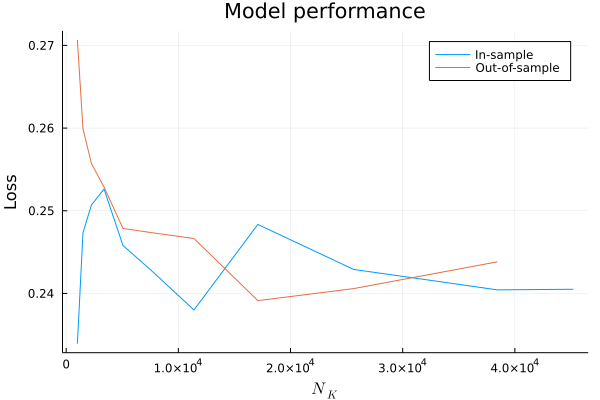

In [11]:
plot(
    results["sample_size"],
    Matrix(results_presentation[:, [:objective_in_sample, :objective_out_of_sample]]),
    label = ["In-sample" "Out-of-sample"],
    xlabel = L"N_K",
    ylabel = "Loss",
    title = "Model performance"
)

The performance seems to plateau once we reach a sample size of about 10,000.

### Learning curves

Let us take a look at how fast the model improves at each iteration:

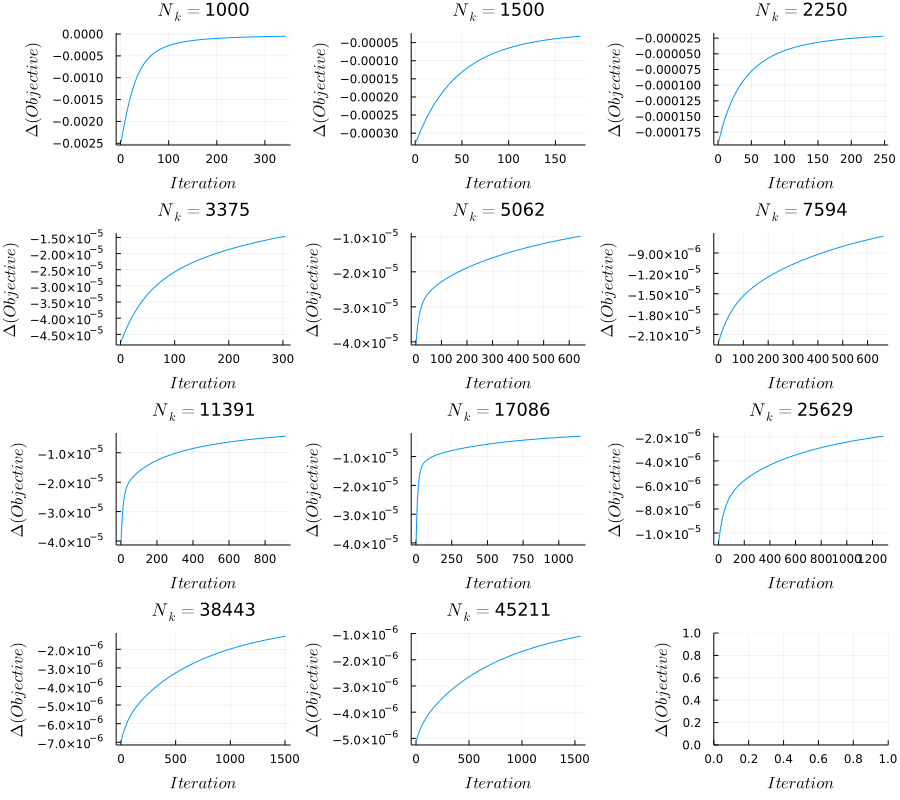

In [12]:
l = @layout grid(Int(ceil(K / 3)), 3)
plot(
    [diff(results["learning"][i]) for i in 1:K],
    layout = l,
    size = (900, 800),
    title = [string(L"N_k=", results["sample_size"][i]) for j in 1:1, i in 1:K],
    titleloc = :center,
    titlefont = font(12),
    legend = false,
    xlabel = L"Iteration",
    ylabel = L"\Delta (Objective)"
)

At the beginning of every major iteration of the algorithm, we see a sharp improvement in performance, which tends to level off as we progress towards the minimum.